In [5]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skopt
from skopt import plots
sns.set(color_codes=True, font_scale=1.2)

sys.path.append('../../../src')
import analyze
import raybay

In [48]:
# Load treatment plan results
opt_result_80 = skopt.load('checkpoint_80.pkl')
goal_dict_80 = np.load('goal_dict_80.pkl', allow_pickle=True)
result = np.load('res_linear_quadratic_dummy_minimize_20.pkl', allow_pickle=True)

In [49]:
# Merge goal results together
goal_dict = {}
for goal in goal_dict_80:
    goal_dict[goal] = goal_dict_80[goal] + result.goal_dict[goal]

In [50]:
# Merge parameters together
x_iters = opt_result_80.x_iters + result.opt_result.x_iters

In [51]:
# Merge function values together
func_vals = np.zeros(100)
func_vals[:80] = opt_result_80.func_vals
func_vals[80:] = result.opt_result.func_vals

In [52]:
# Add everything to result
result.goal_dict = goal_dict
idx_sol = np.argmin(func_vals)
result.opt_result.fun = func_vals[idx_sol]
result.opt_result.func_vals = func_vals
result.opt_result.x = x_iters[idx_sol]
result.opt_result.x_iters = x_iters
result.opt_result.specs['args']['n_calls'] = 100
result.opt_result.specs['args']['n_initial_points'] = 100

In [53]:
# Reload goal and function dataframes (doesn't save correctly from remote)
result.goal_df = pd.read_csv('../goals.csv') 
result.func_df = pd.read_csv('funcs.csv')
pickle.dump(result, open('res_linear_quadratic_dummy_minimize.pkl', 'wb'))

In [30]:
# Clinical goals
result.goal_df

,Roi,Type,GoalCriteria,AcceptanceLevel,ParameterValue
0,Bronchus,MaxDvh,AtMost,1560,18.52
1,Bronchus,MaxDose,AtMost,3480,NaN
2,Chestwall_L,MaxDvh,AtMost,3000,2.04
3,D2cm,MaxDose,AtMost,2400,NaN
4,Esophagus,MaxDvh,AtMost,1880,16.91
5,Esophagus,MaxDose,AtMost,3000,NaN
6,GreatVes,MaxDvh,AtMost,4300,5.66
7,GreatVes,MaxDose,AtMost,4900,NaN
8,Heart,MaxDvh,AtMost,2800,1.84
9,Heart,MaxDose,AtMost,3400,NaN


In [31]:
# Constituent functions
result.func_df

,Roi,FunctionType,DoseLevel,PercentVolume,EudParameterA,Weight
0,Bronchus,MaxDvh,1560,18.52,NaN,1
1,Bronchus,MaxDose,3480,0.00,NaN,1
2,Chestwall_L,MaxDvh,3000,2.04,NaN,1
3,D2cm,MaxDose,"[0,2400]",0.00,NaN,1
4,Esophagus,MaxDvh,1880,16.91,NaN,1
5,Esophagus,MaxDose,3000,0.00,NaN,1
6,GreatVes,MaxDvh,4300,5.66,NaN,1
7,GreatVes,MaxDose,4900,0.00,NaN,1
8,Heart,MaxDvh,2800,1.84,NaN,1
9,Heart,MaxDose,3400,0.00,NaN,1


In [32]:
# Clinical goal results
idx_sol = np.argmin(result.opt_result.func_vals)
compare = pd.DataFrame()
for index, row in result.goal_df.iterrows():
    roi = row['Roi']
    goal_type = row['Type']
    level = row['AcceptanceLevel']
    value = result.goal_dict[index][idx_sol]
    percent = 100*(value - level)/level
    compare = compare.append({'Roi': roi, 'Type': goal_type, 'AcceptanceLevel': level, 
                              'GoalValue': value, 'PercentChange': percent}, ignore_index=True)
compare = compare[['Roi', 'Type', 'AcceptanceLevel', 'GoalValue', 'PercentChange']] # enforce column order
compare

,Roi,Type,AcceptanceLevel,GoalValue,PercentChange
0,Bronchus,MaxDvh,1560.0,891.398071,-42.859098
1,Bronchus,MaxDose,3480.0,2027.259155,-41.745427
2,Chestwall_L,MaxDvh,3000.0,1751.869750,-41.604342
3,D2cm,MaxDose,2400.0,2413.115723,0.546488
4,Esophagus,MaxDvh,1880.0,641.656379,-65.869342
5,Esophagus,MaxDose,3000.0,1010.285950,-66.323802
6,GreatVes,MaxDvh,4300.0,1002.469943,-76.686746
7,GreatVes,MaxDose,4900.0,1382.472046,-71.786285
8,Heart,MaxDvh,2800.0,877.227659,-68.670441
9,Heart,MaxDose,3400.0,1451.240112,-57.316467


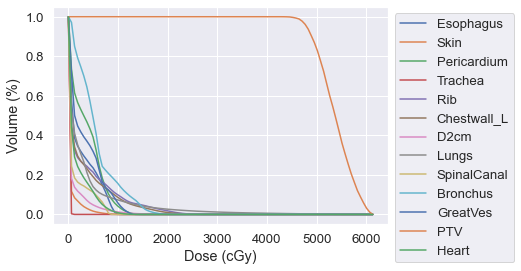

In [33]:
# Dose-volume histograms
result.dvhplot()

In [34]:
# Utility function values
lin = result.get_utility('linear')[idx_sol]
lin_quad = result.get_utility('linear_quadratic')[idx_sol]
print(f"Linear: {lin:.2f}, Linear-Quadratic: {lin_quad:.2f}")

Linear: 1250.32, Linear-Quadratic: 1245.43


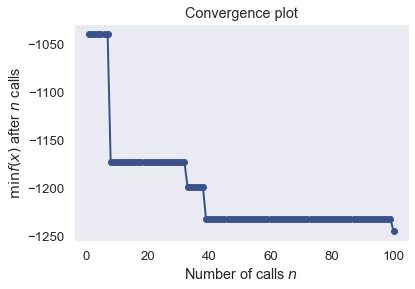

In [35]:
# Convergence
plots.plot_convergence(result.opt_result);

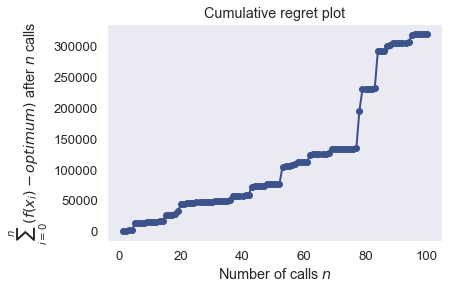

In [36]:
# Regret
plots.plot_regret(result.opt_result);

(-1300.0, 0.0)

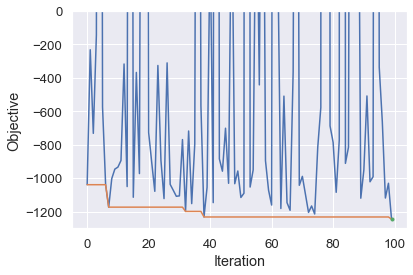

In [56]:
# Objective convergence
idx_sol = np.argmin(result.opt_result.func_vals)
plt.plot(result.opt_result.func_vals)
plt.plot(np.minimum.accumulate(result.opt_result.func_vals))
plt.plot(idx_sol, result.opt_result.fun, '.')
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.ylim([-1300, 0])

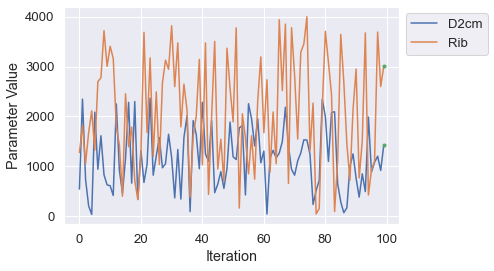

In [57]:
# Parameter convergence
plt.plot(result.opt_result.x_iters)
plt.plot(idx_sol*np.ones(2), result.opt_result.x_iters[idx_sol], '.')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend(['D2cm', 'Rib'], bbox_to_anchor=(1, 1))

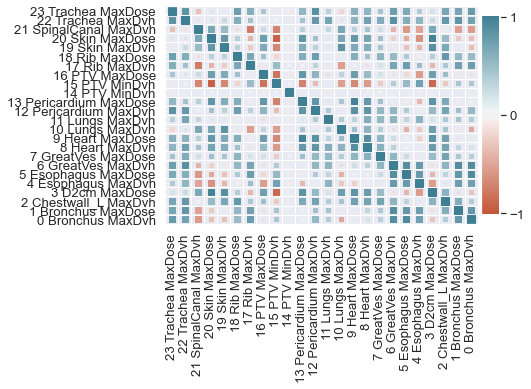

In [58]:
# Goal correlations
result.corrplot(size=50)

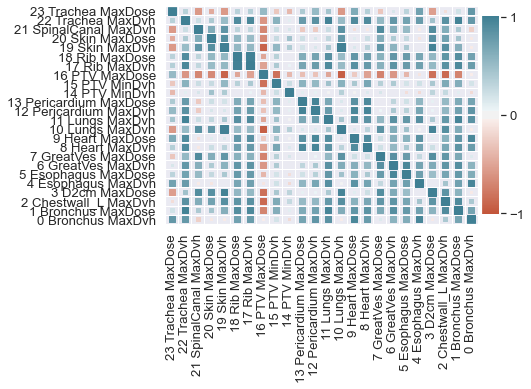

In [59]:
# What if I zero in on a specific parameter range?
x_iters = np.array(result.opt_result.x_iters)
idx_half = np.argwhere((x_iters[:,0] >= 1200) & (x_iters[:,1] >= 2000)).flatten()
goal_dict_half = {ii: np.array(result.goal_dict[ii])[idx_half] for ii in result.goal_dict}
analyze.corrplot(result.goal_df, goal_dict_half, size=50)

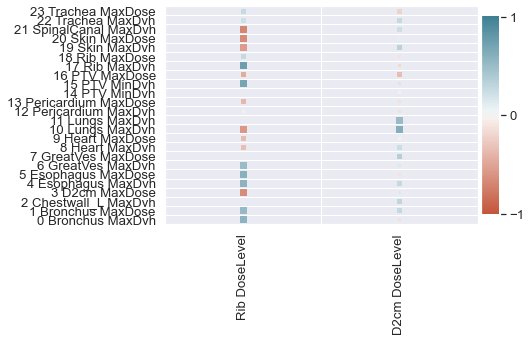

In [60]:
# Parameter correlations
result.corrplot('pars', size=50)

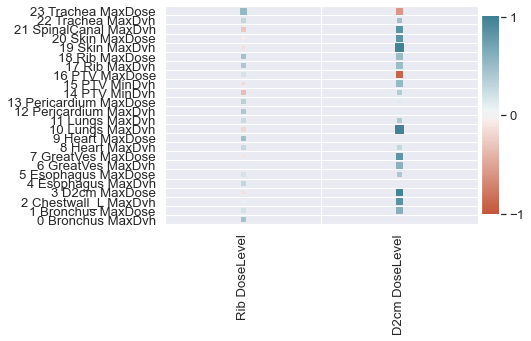

In [61]:
# What if I zero in on a specific parameter range?
analyze.corrplot(result.goal_df, goal_dict_half, result.func_df, x_iters[idx_half], size=50)

<IPython.core.display.Javascript object>


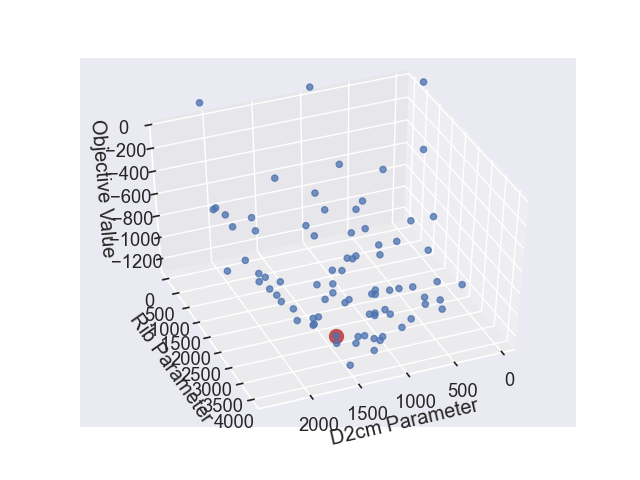

In [62]:
# Parameters vs. Objective
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D([row[0] for row in result.opt_result.x_iters], 
             [row[1] for row in result.opt_result.x_iters], 
             result.opt_result.func_vals)
ax.scatter3D(x_iters[idx_sol][0], x_iters[idx_sol][1], result.opt_result.fun, c='r', s=100)
ax.set_xlabel('D2cm Parameter')
ax.set_ylabel('Rib Parameter')
ax.set_zlabel('Objective Value')
ax.set_zlim([-1300, 0]);

<IPython.core.display.Javascript object>


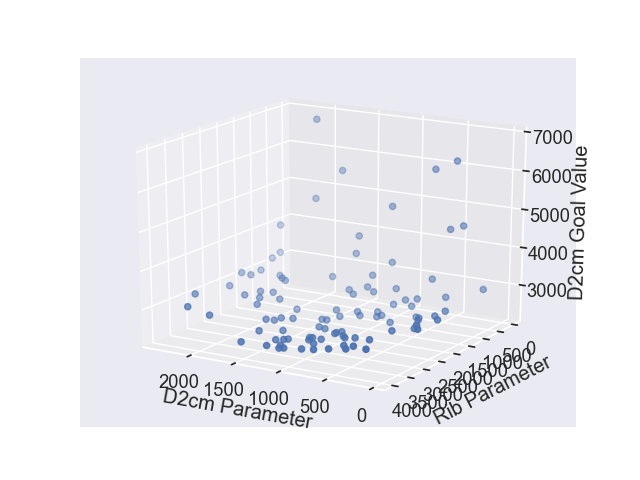

Text(0.5, 0, 'D2cm Goal Value')

In [63]:
# Parameters vs. D2cm Goal
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D([row[0] for row in result.opt_result.x_iters], 
             [row[1] for row in result.opt_result.x_iters], 
             result.goal_dict[3])
ax.set_xlabel('D2cm Parameter')
ax.set_ylabel('Rib Parameter')
ax.set_zlabel('D2cm Goal Value')

<IPython.core.display.Javascript object>


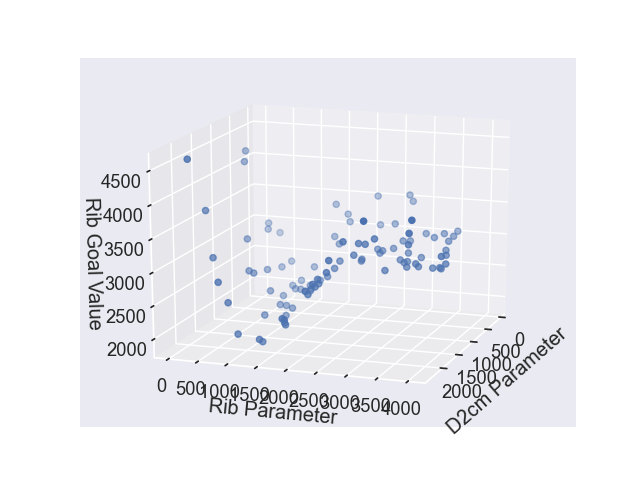

Text(0.5, 0, 'Rib Goal Value')

In [64]:
# Parameters vs. Rib Goal
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D([row[0] for row in result.opt_result.x_iters], 
             [row[1] for row in result.opt_result.x_iters], 
             result.goal_dict[18])
ax.set_xlabel('D2cm Parameter')
ax.set_ylabel('Rib Parameter')
ax.set_zlabel('Rib Goal Value')

In [65]:
result.opt_result.x

[1429.4906712488983, 3007.8142445688304]